In [1]:
from skimage import io
import pandas as pd
import numpy as np

In [2]:
from sklearn import cross_validation, metrics
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
model = RandomForestClassifier(n_jobs = -1, random_state = 0)
parameter_grid = {
    'n_estimators' : [50, 100, 150, 200, 350],
    'max_depth' : [5, 10, 12, 15, 30],
    'min_samples_split' : [2, 4, 8],
    'min_samples_leaf' : [1, 2, 5],
}

In [5]:
data = pd.read_csv('csv/DATASET_3a.csv')

In [6]:
data_good_pixels = pd.DataFrame()#data = [range(0,1964061)])

In [7]:
data.head(3)

,bottom,middle,top,users,y
0,shoes/PT001AWNYQ43_4094966_1_v1.jpg,pants/IC647EWMWF91_4177819_1_v1.jpg,jampers/OO001EWPJQ27_4190535_1_v2.jpg,alex_test,1.0
1,shoes/CA086AWLTL36_1_v1.jpg,pants/IN002EWLKW42_1_v1.jpg,jampers/TO029EWMOQ83_3943245_1_v1.jpg,strak,1.0
2,high_heels/AN003AWKYU95_1_v1.jpg,jeans/AL006EWIIB35_1_v1.jpg,jampers/BA007EWLBR09_1_v2.jpg,strak,1.0


In [8]:
%%time
index_data = 0
for index in range(0,500):
    try:
        img_top = io.imread(path + 'top/' + data.top.loc[index]).ravel()
        img_middle = io.imread(path + 'middle/' + data.middle.loc[index]).ravel()
        img_bottom = io.imread(path + 'bottom/' + data.bottom.loc[index]).ravel()
        data_good_pixels.insert(index_data,index,np.array([img_top, img_middle, img_bottom]).ravel())
        index_data = index_data + 1
    except:
        print str(index)

280
CPU times: user 18.5 s, sys: 2.18 s, total: 20.6 s
Wall time: 21.7 s


In [9]:
data_bad_pixels = pd.DataFrame()

In [10]:
%%time
index_data = 0
for index in range(2000,2500):
    try:
        img_top = io.imread(path + 'top/' + data.top.loc[index]).ravel()
        img_middle = io.imread(path + 'middle/' + data.middle.loc[index]).ravel()
        img_bottom = io.imread(path + 'bottom/' + data.bottom.loc[index]).ravel()
        data_bad_pixels.insert(index_data,index,np.array([img_top, img_middle, img_bottom]).ravel())
        index_data = index_data + 1
    except:
        print str(index)

CPU times: user 18.3 s, sys: 2.04 s, total: 20.4 s
Wall time: 21.4 s


In [11]:
#transform bad and good dataset + y = data

In [12]:
data_good_pixels = data_good_pixels.transpose()

In [13]:
data_bad_pixels = data_bad_pixels.transpose()

In [14]:
y_pos = np.ones(len(data_good_pixels))
y_neg = np.zeros(len(data_bad_pixels))

In [15]:
data_bad_pixels.insert(0,'y',y_neg)
data_good_pixels.insert(0,'y',y_pos)

In [16]:
data = data_good_pixels.append(data_bad_pixels)

In [17]:
%%time
del data_bad_pixels
del data_good_pixels

CPU times: user 10.9 ms, sys: 132 ms, total: 142 ms
Wall time: 143 ms


In [18]:
data.index = range(0,len(data))

# Train Test

In [19]:
from sklearn.cross_validation import StratifiedShuffleSplit

In [22]:
%%time
from sklearn.cross_validation import train_test_split

train_X, test_X, train_Y,test_Y = train_test_split(data.drop(['y'],1), data.y, test_size=0.3, random_state=42)

CPU times: user 7.5 s, sys: 7.1 s, total: 14.6 s
Wall time: 18.1 s


In [23]:
del data

In [24]:
random_search_roc_auc = RandomizedSearchCV(model, parameter_grid, n_iter = 5, scoring='roc_auc', 
                                   cv = cross_validation.StratifiedShuffleSplit(train_Y, n_iter = 5, test_size = 0.3),
                                  )

In [25]:
%%time
random_search_roc_auc.fit(train_X, train_Y)

CPU times: user 15min, sys: 4min 37s, total: 19min 37s
Wall time: 11min 44s


RandomizedSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  1.], n_iter=5, test_size=0.3, random_state=None),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 350], 'min_samples_split': [2, 4, 8], 'max_depth': [5, 10, 12, 15, 30], 'min_samples_leaf': [1, 2, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='roc_auc', verbose=0)

In [26]:
best_params_roc_auc = random_search_roc_auc.best_params_
print best_params_roc_auc

{'n_estimators': 150, 'min_samples_split': 8, 'max_depth': 10, 'min_samples_leaf': 2}


In [27]:
%%time
final_model_roc_auc = RandomForestClassifier(n_jobs = -1, random_state = 0, **best_params_roc_auc)
final_model_roc_auc.fit(train_X, train_Y)

CPU times: user 1min 39s, sys: 26.5 s, total: 2min 5s
Wall time: 58.3 s


In [28]:
score = pd.DataFrame(data = [[metrics.accuracy_score(train_Y, final_model_roc_auc.predict(train_X)), metrics.accuracy_score(test_Y, final_model_roc_auc.predict(test_X))],
                             [metrics.roc_auc_score(train_Y, final_model_roc_auc.predict(train_X)), metrics.roc_auc_score(test_Y, final_model_roc_auc.predict(test_X))],
                            [metrics.average_precision_score(train_Y, final_model_roc_auc.predict(train_X)), metrics.average_precision_score(test_Y, final_model_roc_auc.predict(test_X))]])
score.index = ['accuracy','roc_auc','average_precision_score']
score.columns = ['train','test']

In [29]:
score

,train,test
accuracy,0.998569,0.680000
roc_auc,0.998592,0.681869
average_precision_score,0.998551,0.768829


In [30]:
print metrics.classification_report(test_Y, final_model_roc_auc.predict(test_X))

             precision    recall  f1-score   support

        0.0       0.65      0.74      0.69       145
        1.0       0.72      0.63      0.67       155

avg / total       0.68      0.68      0.68       300



Populating the interactive namespace from numpy and matplotlib


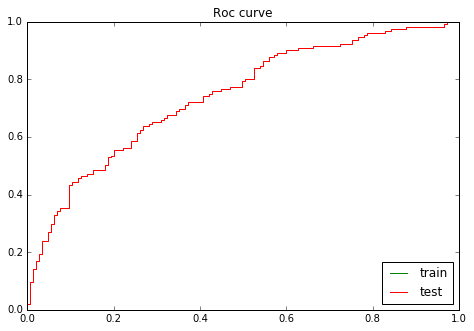

In [31]:
%matplotlib inline
%pylab inline
fpr_test, tpr_test, _test = metrics.roc_curve(test_Y, final_model_roc_auc.predict_proba(test_X)[:,1])
fpr_train, tpr_train, _train = metrics.roc_curve(train_Y, final_model_roc_auc.predict_proba(train_X)[:,1])
pylab.axes([0.0,0.0,1,1])
pylab.plot(fpr_train ,tpr_train, color = 'green', label = 'train')
pylab.plot(fpr_test ,tpr_test, color = 'red', label = 'test')
pylab.title('Roc curve')
pylab.legend(loc = "lower right")

In [32]:
pd.DataFrame(random_search_roc_auc.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{u'n_estimators': 50, u'min_samples_split': 4,...",0.716940,"[0.701161419109, 0.718945649215, 0.71976227202..."
1,"{u'n_estimators': 150, u'min_samples_split': 8...",0.736521,"[0.773886217222, 0.773614009618, 0.67943017875..."
2,"{u'n_estimators': 50, u'min_samples_split': 8,...",0.701152,"[0.673895290808, 0.697123672988, 0.70728609019..."
3,"{u'n_estimators': 50, u'min_samples_split': 2,...",0.688649,"[0.723346338808, 0.674848017421, 0.66414118501..."
4,"{u'n_estimators': 100, u'min_samples_split': 2...",0.736485,"[0.753107703475, 0.749387532892, 0.75492242083..."


In [49]:
print 'train class 1 - ' + str(sum(train_Y))
print 'test class 1 - ' + str(sum(test_Y))
print 'train class 0 - ' + str(len(train_Y) - sum(train_Y))
print 'test class 0 - ' + str(len(test_Y) - sum(test_Y))

train class 1 - 344.0
test class 1 - 155.0
train class 0 - 355.0
test class 0 - 145.0


In [36]:
from sklearn.cross_validation import cross_val_score

cvs = cross_val_score(final_model_roc_auc, test_X, test_Y, scoring="roc_auc", cv = 10)
print cvs

[ 0.6125      0.65416667  0.74166667  0.7625      0.70833333  0.5952381
  0.56666667  0.76190476  0.67619048  0.81904762]
